In [ ]:
# ======================
# LIBRARY IMPORTS
# ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
from yellowbrick.regressor import ResidualsPlot
print('All library are import succesfuly!')

warnings.filterwarnings('ignore')

All library are import succesfuly!


In [ ]:
# ======================
# KAGGLE DATA DOWNLOAD
# ======================
import kagglehub
try:
    vipullrathod_fish_market_path = kagglehub.dataset_download('vipullrathod/fish-market')
    print('Kaggle dataset download complete.')
    df = pd.read_csv(f'{vipullrathod_fish_market_path}/Fish.csv')
    print('Data samples')
    print(df.head())
    print('Data Descriptions')
    print(df.info())



except Exception as e:
    print(f"Kaggle download failed: {e}")
    print("Falling back to alternative data source...")
    try:
        df = pd.read_csv('https://raw.githubusercontent.com/dataprofessor/data/master/fish.csv')
        print("Loaded dataset from GitHub")
    except Exception as e:
        print(f"Failed to load dataset: {e}")
        raise
# Define numeric_features outside the exception block
numeric_features = ['Length1', 'Length2', 'Length3', 'Height', 'Width']

Kaggle dataset download complete.
Data samples
  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Data Descriptions
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB
None


In [ ]:
# ======================
# DATA PREPROCESSING
# ======================
def preprocess_data(df):
    """Clean and prepare the dataset for modeling"""

    # 1. Remove invalid entries
    df = df[df['Weight'] > 0]

    # 2. Handle outliers (based on prior EDA)
    df = df.drop([142, 143, 144], errors='ignore')

    # 3. Feature engineering
    df['Volume_Estimate'] = df['Length1'] * df['Height'] * df['Width']

    # 4. Separate features and target
    X = df.drop('Weight', axis=1)
    y = df['Weight']

    # 5. Define preprocessing pipelines
    # Include 'Volume_Estimate' in numeric_features
    numeric_features = ['Length1', 'Length2', 'Length3', 'Height', 'Width', 'Volume_Estimate']
    categorical_features = ['Species'] # Define categorical_features here for later use

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    return X, y, preprocessor, categorical_features # Return categorical_features

X, y, preprocessor, categorical_features = preprocess_data(df) # Receive categorical_features

In [ ]:
# ======================
# DATA SPLITTING
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"\nData shapes after splitting:")
print(f"Training features: {X_train.shape}")
print(f"Testing features: {X_test.shape}")
print(f"Training target: {y_train.shape}")
print(f"Testing target: {y_test.shape}")


Data shapes after splitting:
Training features: (124, 7)
Testing features: (31, 7)
Training target: (124,)
Testing target: (31,)


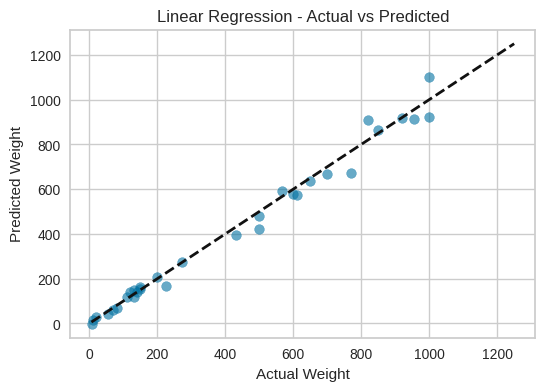

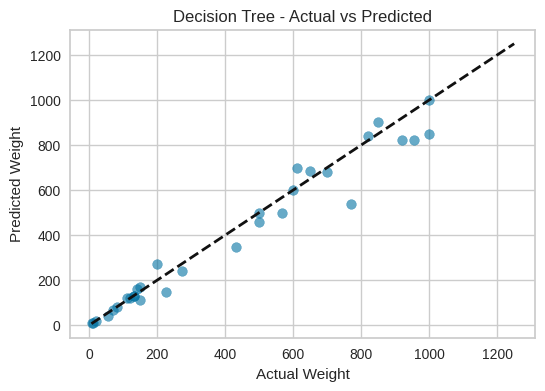

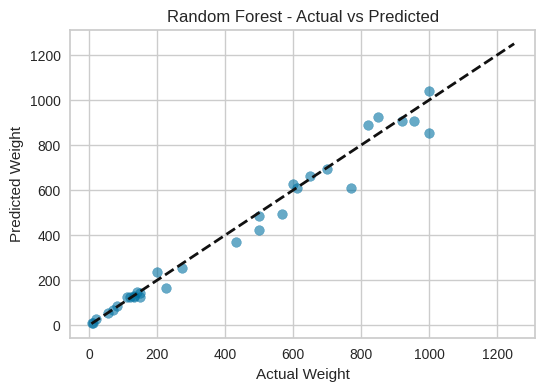

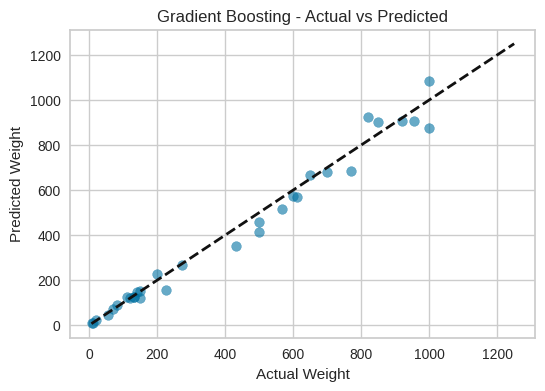


Model Performance Comparison:


,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²,CV R² Mean,CV R² Std
0,Linear Regression,46.077228,40.885607,29.953265,28.637978,0.978381,0.985043,0.966558,0.011905
3,Gradient Boosting,6.660955,48.654938,4.717276,34.192677,0.999548,0.978818,0.966816,0.018466
2,Random Forest,19.587160,52.366677,11.690556,32.978774,0.996093,0.975463,0.965808,0.023204
1,Decision Tree,0.000000,68.366022,0.000000,42.445161,1.000000,0.958179,0.912627,0.043406


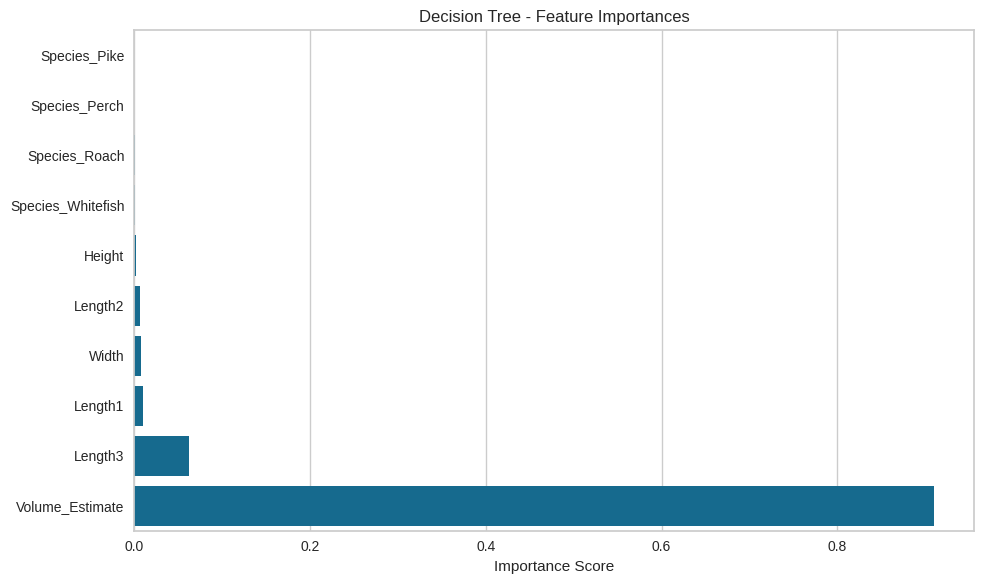

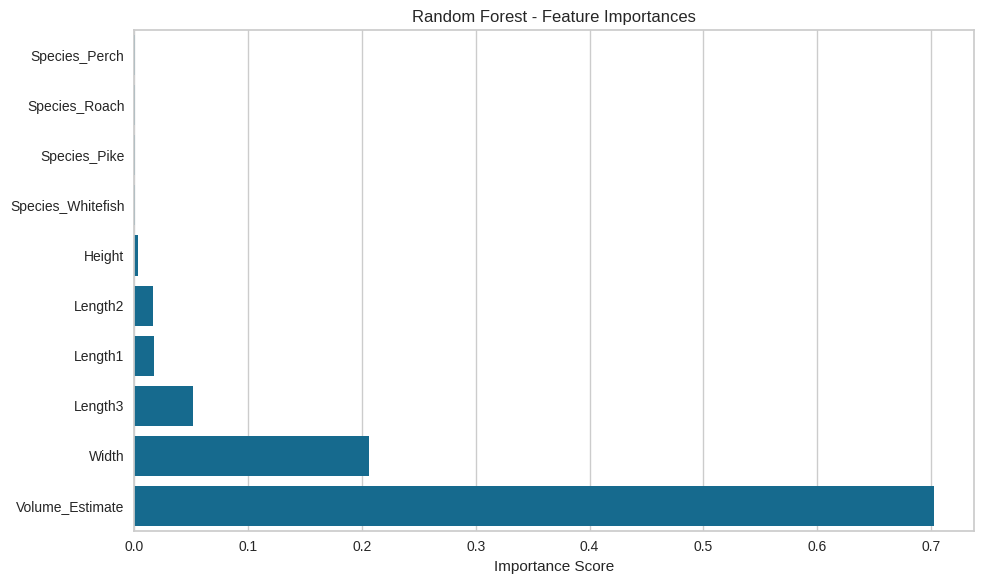

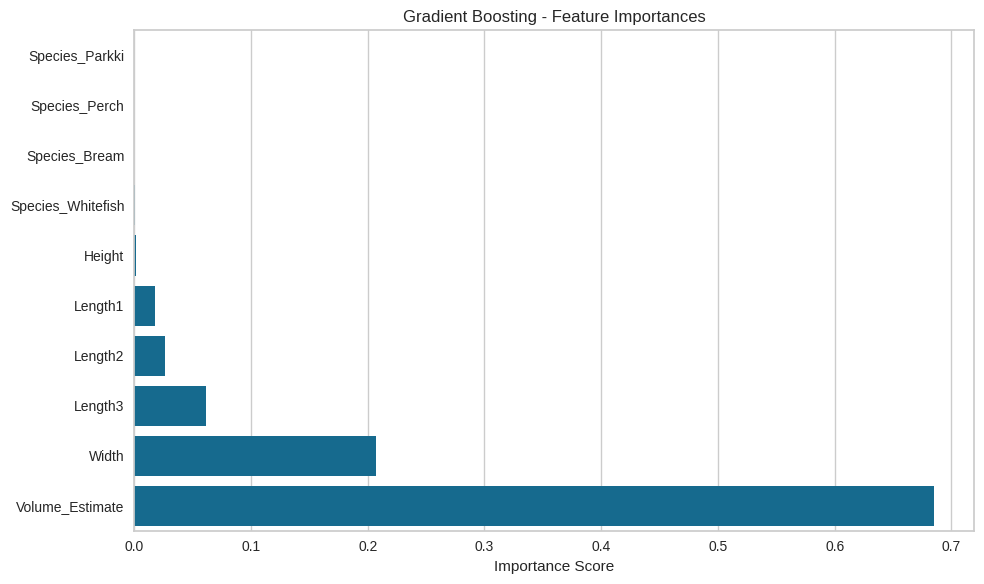

In [ ]:
# ======================
# MODEL TRAINING & EVALUATION
# ======================
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = {
    "Model": [],
    "Train RMSE": [],
    "Test RMSE": [],
     "Train MAE": [],
    "Test MAE": [],
    "Train R²": [],
    "Test R²": [],
    "CV R² Mean": [],
    "CV R² Std": []
}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)


    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

    # Store results
    results["Model"].append(name)
    results["Train RMSE"].append(train_rmse)
    results["Test RMSE"].append(test_rmse)
    results["Train MAE"].append(train_mae)
    results["Test MAE"].append(test_mae)
    results["Test R²"].append(test_r2)
    results["Train R²"].append(train_r2)
    results["CV R² Mean"].append(np.mean(cv_scores))
    results["CV R² Std"].append(np.std(cv_scores))


    # Plot predictions
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual Weight')
    plt.ylabel('Predicted Weight')
    plt.title(f'{name} - Actual vs Predicted')
    plt.show()

# Display results
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
display(results_df.sort_values(by='Test R²', ascending=False))

# Feature Importance for tree-based models
tree_models = {
    "Decision Tree": models["Decision Tree"],
    "Random Forest": models["Random Forest"],
    "Gradient Boosting": models["Gradient Boosting"]
}

for name, model in tree_models.items():
    if hasattr(model, 'feature_importances_'):
        # Get feature names after preprocessing
        numeric_features = ['Length1', 'Length2', 'Length3', 'Height', 'Width', 'Volume_Estimate']
        feature_names = numeric_features + \
                       list(preprocessor.named_transformers_['cat']
                           .named_steps['onehot']
                           .get_feature_names_out(categorical_features))

        importances = model.feature_importances_
        sorted_idx = np.argsort(importances)[-10:]  # Top 10 features

        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
        plt.title(f'{name} - Feature Importances')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

In [ ]:
# ======================
# HYPERPARAMETER TUNING (FOR BEST MODEL)
# ======================

# Identify the best model based on Test R²
best_model_name = results_df.sort_values(by='Test R²', ascending=False).iloc[0]['Model']
print(f"\nPerforming hyperparameter tuning for best model: {best_model_name}")

if best_model_name == "Random Forest":
    # Define parameter grid for Random Forest
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == "Gradient Boosting":
    # Define parameter grid for Gradient Boosting
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
else:
    param_grid = None

if param_grid:
    # Create pipeline for the best model
    best_model = models[best_model_name]
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', best_model)
    ])

    # Setup GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    # Run grid search
    print(f"\nStarting grid search for {best_model_name}...")
    grid_search.fit(X_train, y_train)

    # Results
    print("\nTuning Results:")
    print(f"Best R² Score: {grid_search.best_score_:.3f}")
    print("Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"{param}: {value}")

    # Evaluate on test set
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    print(f"\nTest R² with tuned parameters: {test_r2:.3f}")

    # Compare with default model
    default_test_r2 = results_df[results_df['Model'] == best_model_name]['Test R²'].values[0]
    improvement = test_r2 - default_test_r2
    print(f"Improvement over default: {improvement:.3f} R² points")

    # Feature importance for tuned model
    if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
        importances = best_pipeline.named_steps['model'].feature_importances_
        feature_names = numeric_features + \
                       list(preprocessor.named_transformers_['cat']
                           .named_steps['onehot']
                           .get_feature_names_out(categorical_features))

        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances, y=feature_names)
        plt.title(f'Tuned {best_model_name} - Feature Importances')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
else:
    print(f"\nHyperparameter tuning not implemented for {best_model_name}")


Performing hyperparameter tuning for best model: Linear Regression

Hyperparameter tuning not implemented for Linear Regression



Residual Analysis:


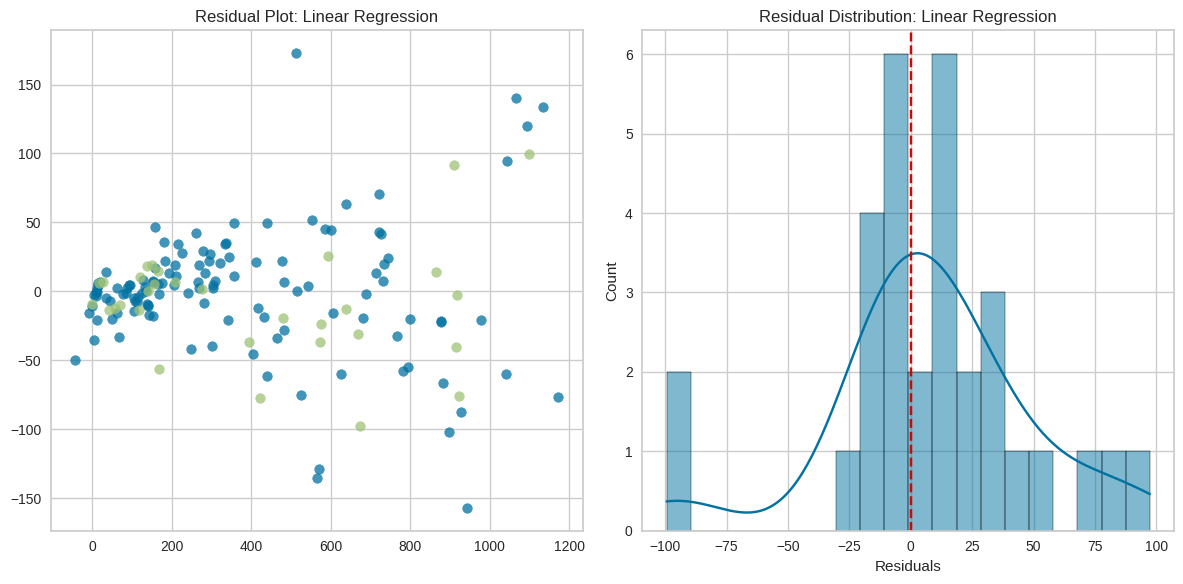

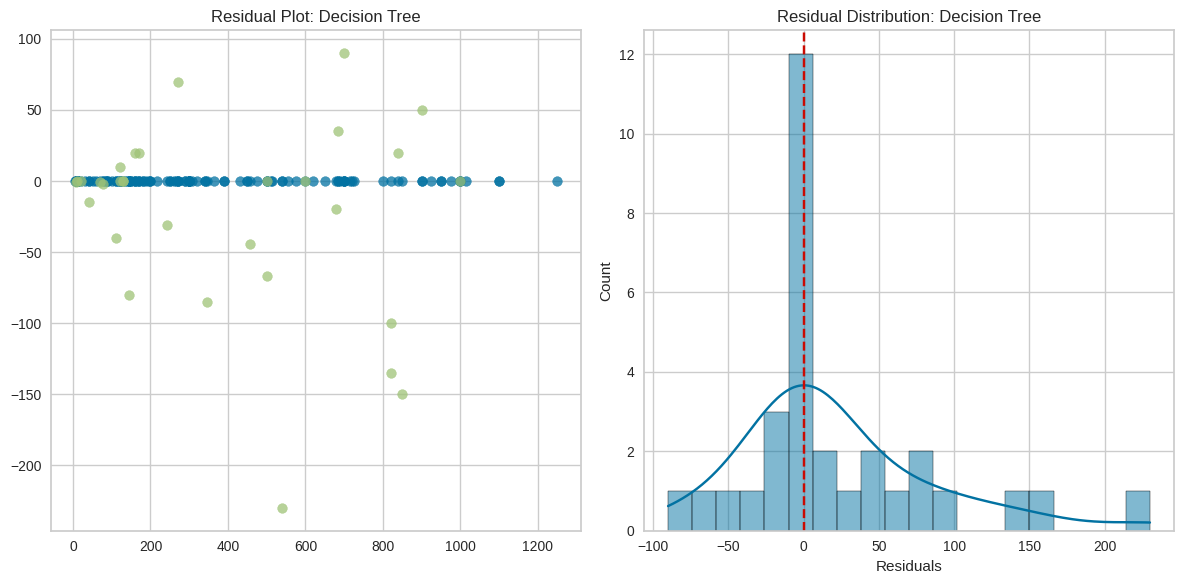

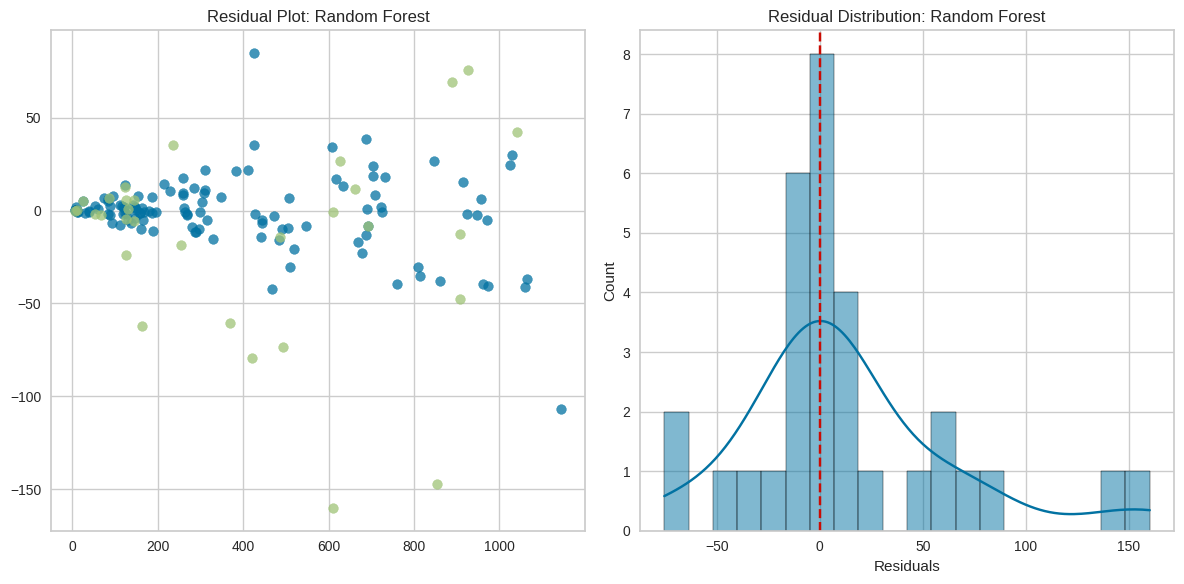

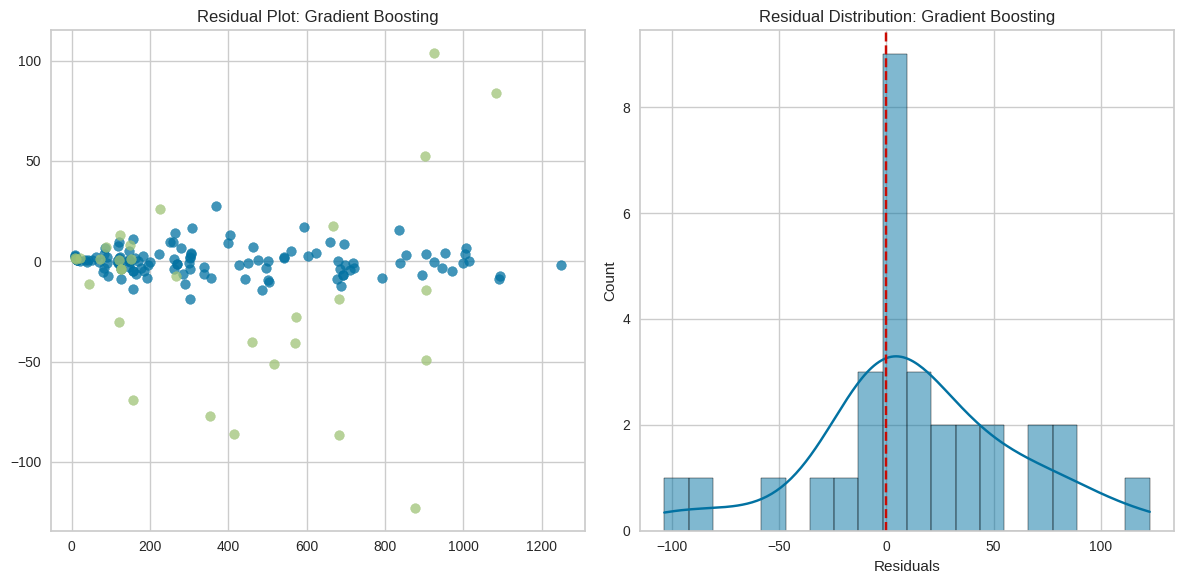


Learning Curves Analysis:


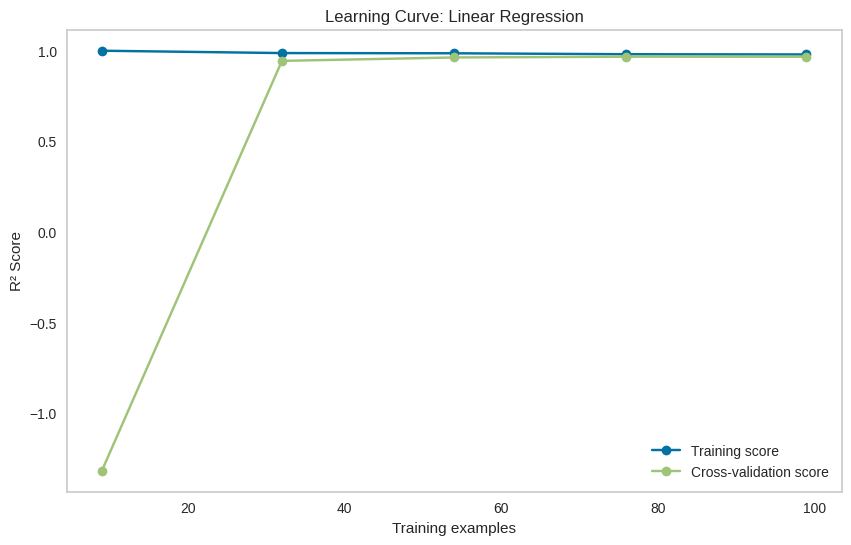

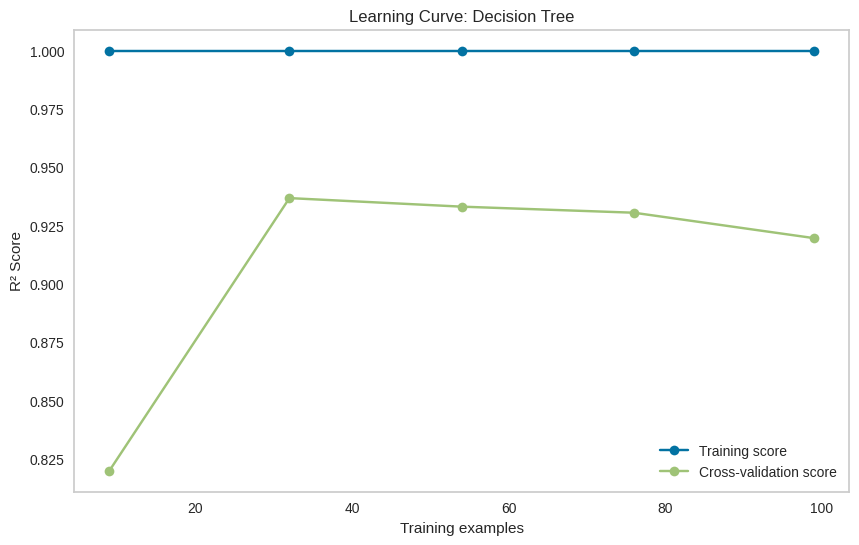

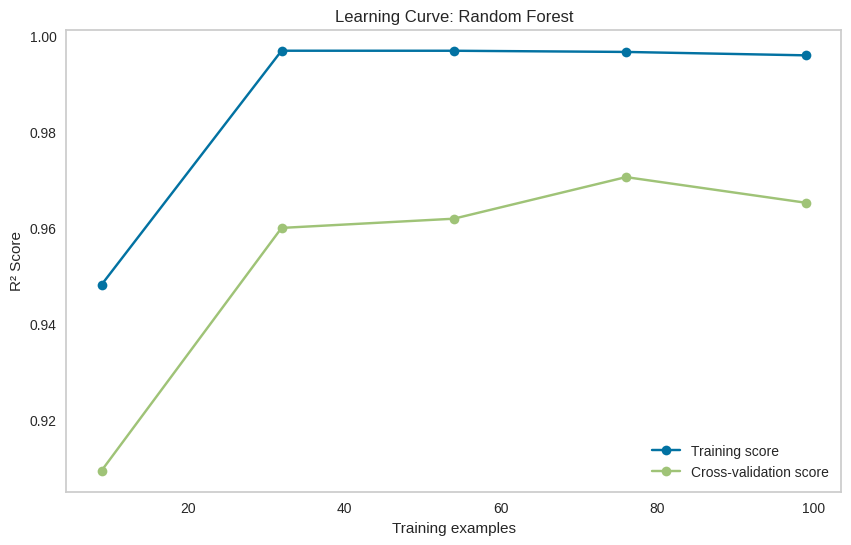

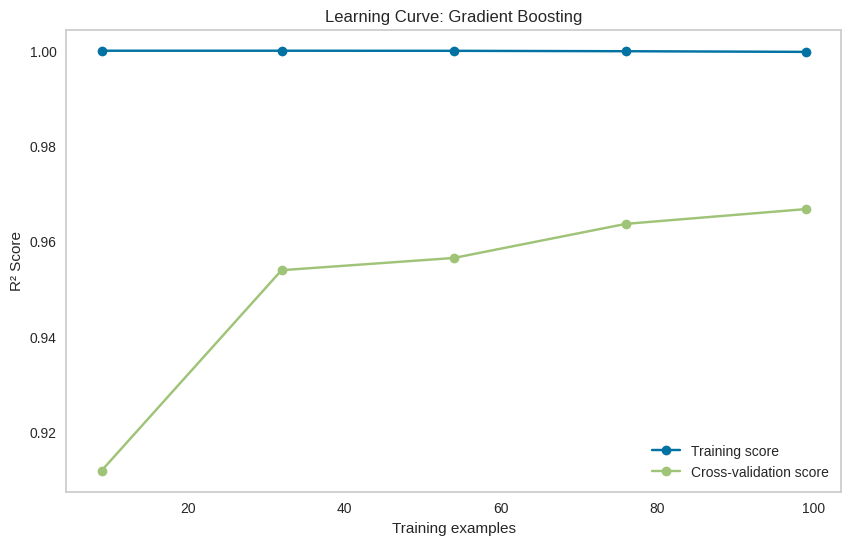


Prediction Error Analysis:


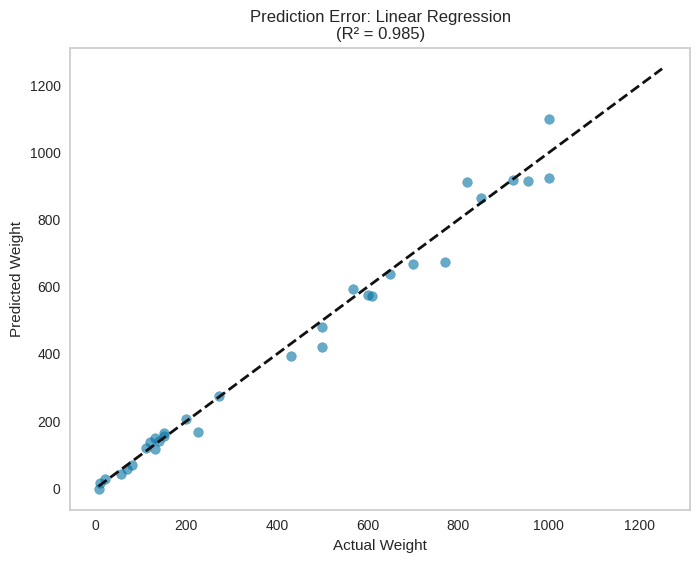

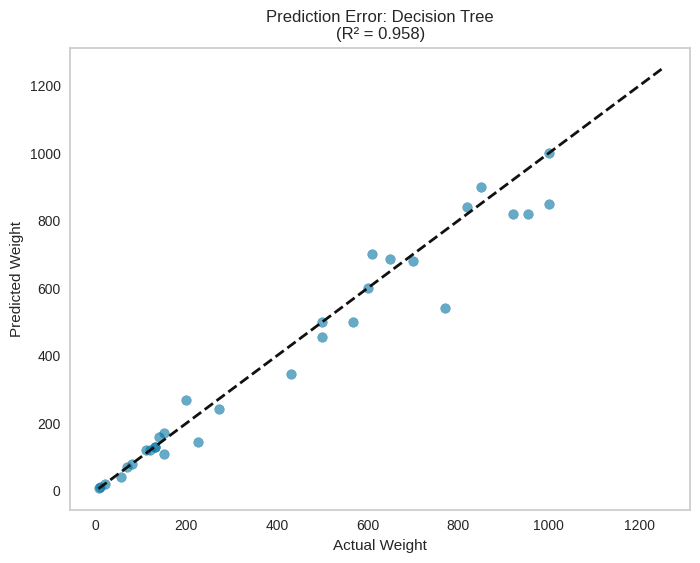

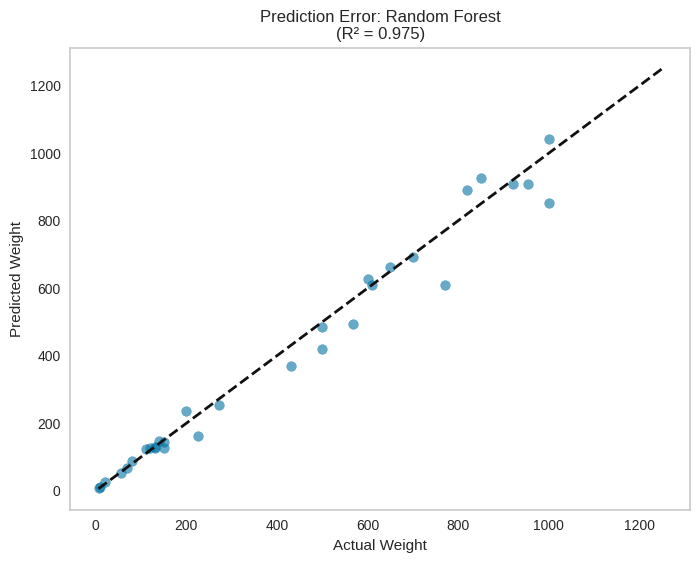

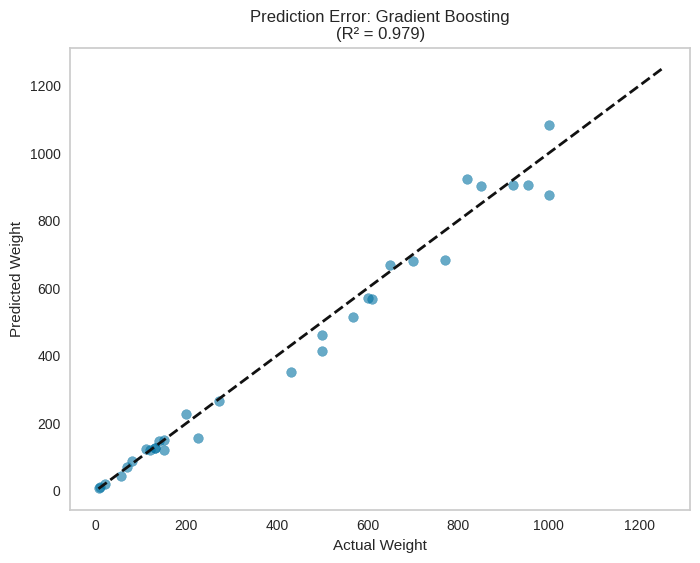


Feature Importance Comparison:
Number of importances: 3
Feature names: ['Length1', 'Length2', 'Length3', 'Height', 'Width', 'Volume_Estimate', 'Species_Bream', 'Species_Parkki', 'Species_Perch', 'Species_Pike', 'Species_Roach', 'Species_Smelt', 'Species_Whitefish']


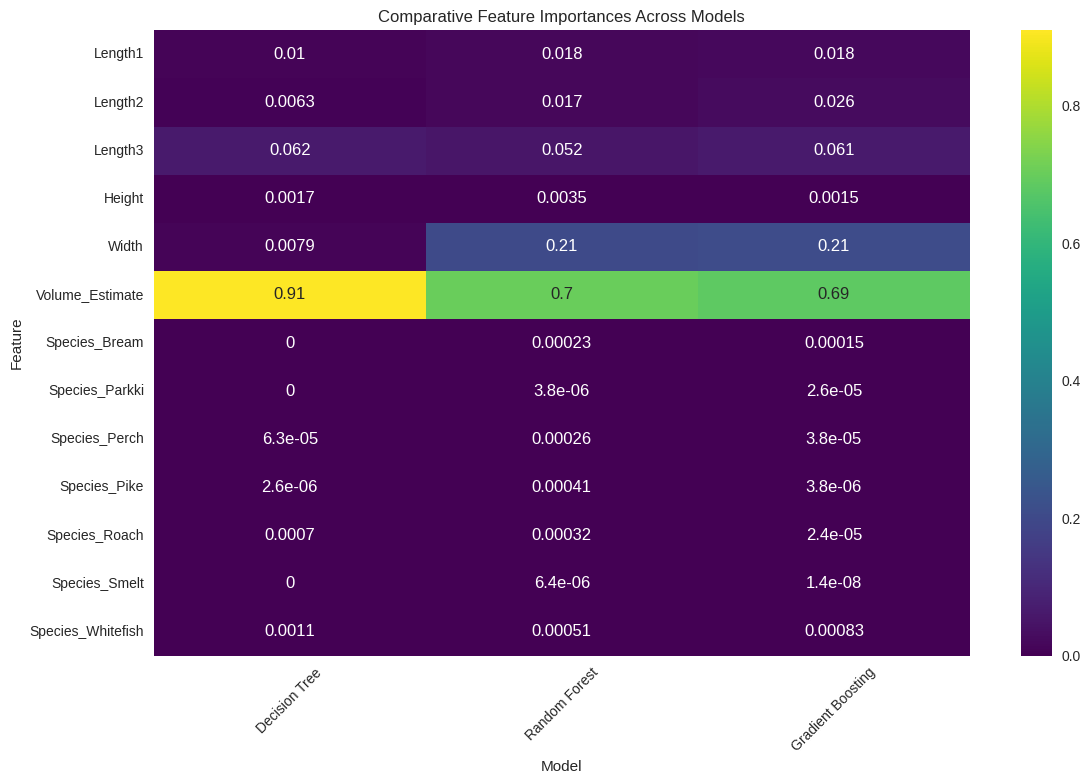


Error Distribution Analysis:


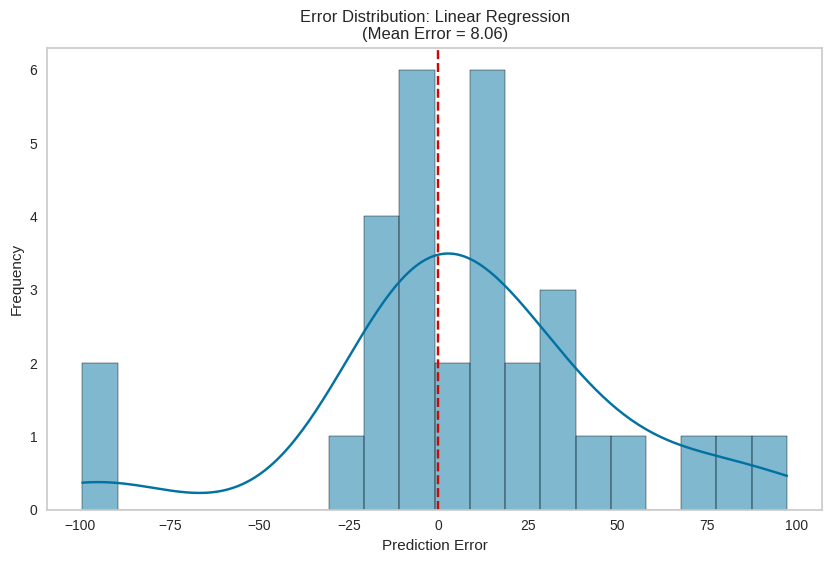

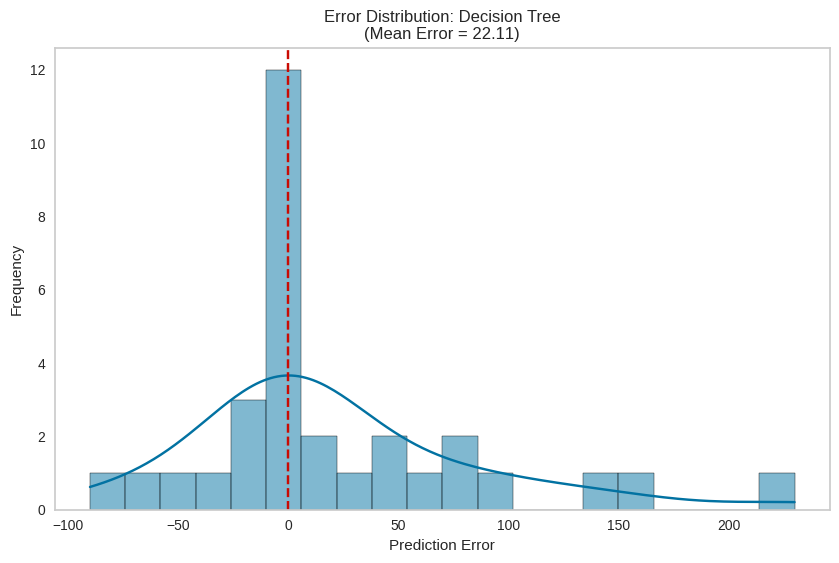

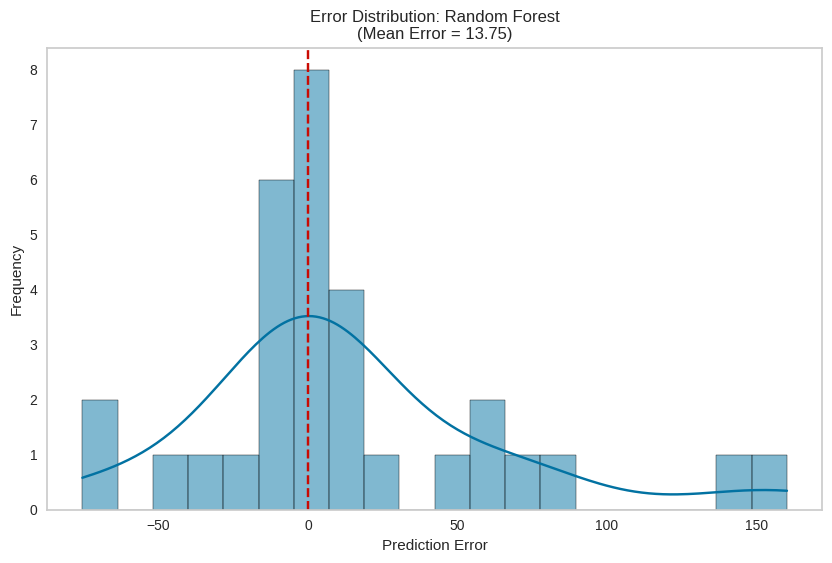

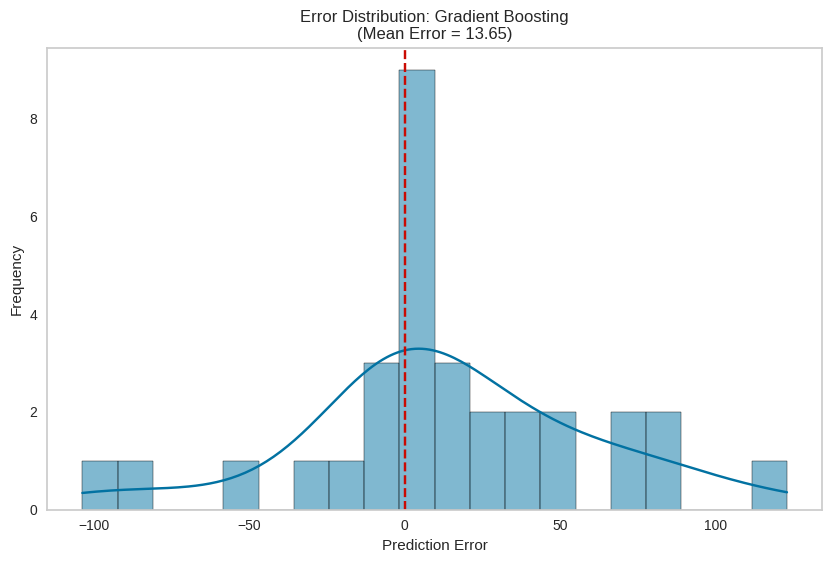


Final Model Comparison:


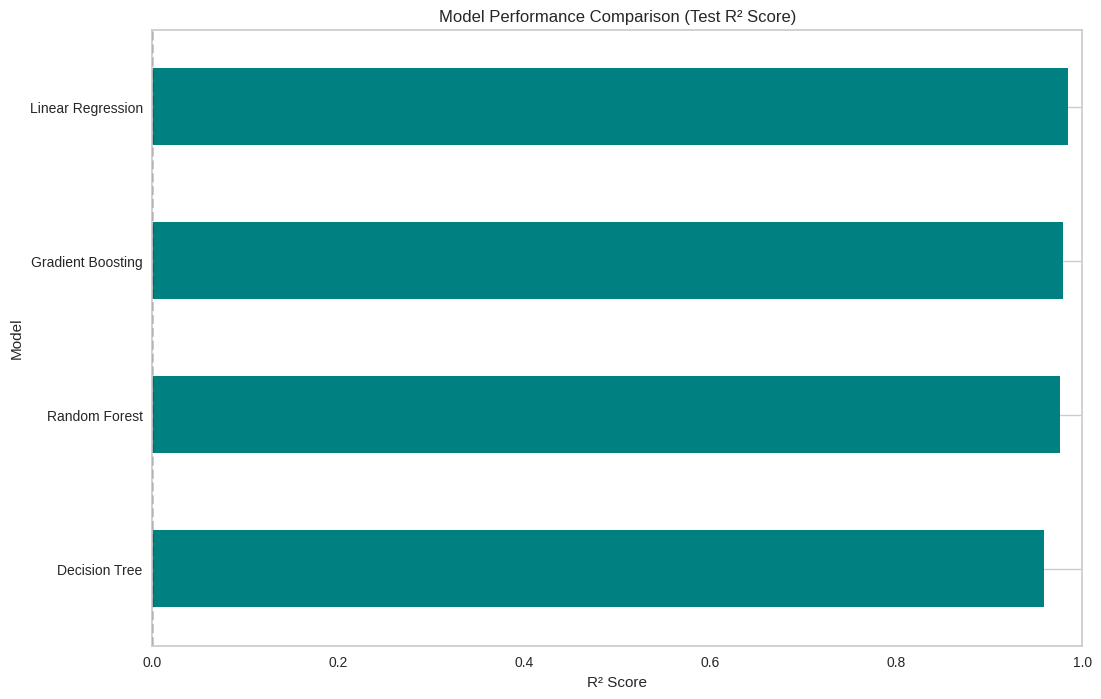

In [ ]:
# ======================
# ENHANCED TESTING & EVALUATION
# ======================

# 1. Residual Analysis for each model
print("\nResidual Analysis:")
for name, model in models.items():
    plt.figure(figsize=(12, 6))

    # Create and fit the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)

    # Create subplots for residual plot and histogram
    plt.subplot(1, 2, 1)  # Left plot for residuals
    visualizer = ResidualsPlot(pipeline, hist=False, qqplot=False)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.ax.set_title(f'Residual Plot: {name}')

    plt.subplot(1, 2, 2)  # Right plot for histogram
    y_pred = pipeline.predict(X_test)
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, bins=20, ax=plt.gca())
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'Residual Distribution: {name}')
    plt.xlabel('Residuals')

    plt.tight_layout()
    plt.show()

# 2. Learning Curves Analysis
def plot_learning_curve(model, title):
    plt.figure(figsize=(10, 6))
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='r2',
        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
    plt.title(f"Learning Curve: {title}")
    plt.xlabel("Training examples")
    plt.ylabel("R² Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

print("\nLearning Curves Analysis:")
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    plot_learning_curve(pipeline, name)

# 3. Prediction Error Analysis
print("\nPrediction Error Analysis:")
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual Weight')
    plt.ylabel('Predicted Weight')
    plt.title(f'Prediction Error: {name}\n(R² = {r2_score(y_test, y_pred):.3f})')
    plt.grid()
    plt.show()

# 4. Feature Importance Comparison
print("\nFeature Importance Comparison:")
all_importances = []
for name, model in tree_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        all_importances.append(importances)

if len(all_importances) > 0:
    # Correctly get feature names after preprocessing
    numeric_features = ['Length1', 'Length2', 'Length3', 'Height', 'Width', 'Volume_Estimate']
    feature_names = numeric_features + \
                   list(preprocessor.named_transformers_['cat']
                       .named_steps['onehot']
                       .get_feature_names_out(categorical_features))

    # Debugging prints
    print(f"Number of importances: {len(all_importances)}")
    print(f"Feature names: {feature_names}")

    # Ensure all_importances has the correct shape
    importance_df = pd.DataFrame(all_importances,
                                  columns=feature_names[:len(all_importances[0])],
                                  index=list(tree_models.keys()))

    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df.T, annot=True, cmap='viridis')
    plt.title('Comparative Feature Importances Across Models')
    plt.xlabel('Model')
    plt.ylabel('Feature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No tree models found with feature importances.")

# 5. Error Distribution Analysis
print("\nError Distribution Analysis:")
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    errors = y_test - y_pred

    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=20)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'Error Distribution: {name}\n(Mean Error = {np.mean(errors):.2f})')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

# 6. Model Comparison Plot
print("\nFinal Model Comparison:")
plt.figure(figsize=(12, 8))
results_df.set_index('Model')['Test R²'].sort_values().plot(kind='barh', color='teal')
plt.axvline(x=0, color='k', linestyle='--')
plt.title('Model Performance Comparison (Test R² Score)')
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.grid(axis='x')
plt.show()